In [ ]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import sympy as sym

In [ ]:
# setup of variables
m1,m2,m3,k1,k2,k3,k4,time = sym.symbols('m_1,m_2,m_3,k_1,k_2,k_3,k_4,t') # constants and time
x1 = sym.Function(r'\x_1')(time) # angles
x2 = sym.Function(r'\x_2')(time)
x3 = sym.Function(r'\x_3')(time)
x1d = x1.diff(time) # angular velocites
x2d = x2.diff(time)
x3d = x3.diff(time)
x1dd = x1.diff(time,2) # angular acceleration (we will be solving for these, but it will be useful to have them defined as symbols)
x2dd = x2.diff(time,2)
x3dd = x3.diff(time,2)

# Lagrangian Setup
T = 0.5 * (k1 * x1**2 + k2 * (x1 - x2)**2 + k3 * (x2 - x3)**2 + k4 * x3**2)
V =  0.5 * (m1* x1d **2 + m2 * x2d**2 + m3 * x3d **2)
L = T - V

# Get EOMs from Euler-Lagrange Equation:
left = L.diff(x1)
right = L.diff(x1d).diff(time)
x1dd = sym.solve(sym.Eq(left,right),x1dd)

left1 = L.diff(x2)
right1 = L.diff(x2d).diff(time)
x2dd = sym.solve(sym.Eq(left1,right1),x2dd)

left2 = L.diff(x3)
right2 = L.diff(x3d).diff(time)
x3dd = sym.solve(sym.Eq(left2,right2),x3dd)

print(x1dd,"\n",x2dd,"\n",x3dd)

x1dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x1dd,'numpy')
x2dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x2dd,'numpy')
x3dd_f = sym.lambdify([m1,m2,m3,k1,k2,k3,k4,x1,x2,x3],x3dd,'numpy')

def derivs(t,curr_vals,m1,m2,m3,k1,k2,k3,k4):

    x1,x1d,x2,x2d,x3,x3d = curr_vals

    return x1d, x1dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x2d, x2dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0], x3d, x3dd_f(m1,m2,m3,k1,k2,k3,k4,x1,x2,x3)[0]

Initial condition in order: $x_1, \dot{x}_1,x_2, \dot{x}_2,x_3, \dot{x}_3$

In [ ]:
initial = [1,0,0,0,0,0]

tmax = 10
dt = 0.05
t = np.arange(0,tmax,dt)

m1 = 1.
m2 = 1.
m3 = 1.
k1 = 1.
k2 = 1.
k3 = 1.
k4 = 1.
#print(derivs(t,initial,m1,m2,m3,k1,k2,k3,k4))
solved = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4))

noise_sigma = 0.02
y_true = solved.y #+  noise_sigma* np.random.randn(6,len(t))
x1,x2,x3 = y_true[0], y_true[2], y_true[4]

positions = np.array([solved.y[i] for i in [0,2,4]])

# plt.figure(figsize=(16,5))
# plt.plot(t,solved.y[0],label = 0) # x1
# plt.plot(t,solved.y[2],label = 1) #x2 #x3
# plt.plot(t,solved.y[4],label = 2)
# plt.legend()
# plt.grid()
# plt.show()

plt.figure(figsize = (16,5))
# plt.plot(t,solved.y[1],label = 3)
# plt.plot(t,solved.y[3],label = 4)
# plt.plot(t,solved.y[5],label = 5)
plt.plot(t,x1, label = 'x1')
plt.plot(t,x2, label = "x2")
plt.plot(t,x3, label = "x3")
plt.legend()
plt.grid()
plt.show()

In [ ]:
sigma = 0.1
def log_likelihood(theta):
    k1,k2,k3,k4 = theta
    sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA")
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)

D = 4
LB = np.full((1, D), 0.0)  # Lower bounds
UB = np.full((1, D), 100.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 4.0 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off"
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

In [ ]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

In [ ]:
Xs, _ = vp.sample(int(1e6))
vp.plot();

In [ ]:
# for i in range(4):
#     plt.figure(figsize = (6,6))
#     plt.hist2d(Xs[:,i-1],Xs[:,i], bins = 100)
#     plt.title(str(i-1) + str(" ")+str(i))
#     plt.xlim(0.95,1.03)
#     plt.ylim(0.95,1.03)
#     plt.axis("equal")
#     plt.show()

In [ ]:
def log_likelihood(theta):
    k1,k2,k3,k4,m1,m2,m3 = theta
    sol = solve_ivp(derivs,(0,tmax),initial,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA")
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)


D = 7
LB = np.full((1, D), 0)  # Lower bounds
UB = np.full((1, D), 50.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 1.5 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "max_fun_evals": 1000
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

In [ ]:
vbmc2 = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp2, results2 = vbmc2.optimize() # do optimization (might take a while)

In [ ]:
vp2.plot();

In [ ]:
initial1 = [0,1,0,0,0,0]
initial2 = [1,0,0,-0.2,3.5,0]
initial3 = [0,1,1,-0.5,0,-0.2]
initial4 = [3,3,1,-0.5,-1,-0.5]

initial_conditions = [initial1,initial2,initial3,initial4]
noise_sigma = 0.03
sigma = noise_sigma


sols = []
for initial_condition in initial_conditions:
    sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y + noise_sigma* np.random.randn(6,len(t))
    sols.append(np.array([sol[i] for i in [0,2,4]]))
big_t = np.arange(0,4*tmax,dt )
big_sol = np.concatenate(sols, axis = 1)
y_true = big_sol[:,0::4]

def log_likelihood(theta):
    k1,k2,k3,k4 = theta
    sols = []
    for initial_condition in initial_conditions:
        sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y
        sols.append(np.array([sol[i] for i in [0,2,4]]))
    big_sol = np.concatenate(sols, axis = 1)
    sliced_sol = big_sol[:,0::4]
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sliced_sol)**2)

plt.figure(figsize = (16,5))
plt.plot(big_t[0::4],y_true[0], label = "x1")
plt.plot(big_t[0::4],y_true[1], label = "x2")
plt.plot(big_t[0::4],y_true[2], label = "x3")
print(len(y_true[0]))
plt.grid()
plt.legend()
plt.show()

In [8]:
D = 4
LB = np.full((1, D), 0.0)  # Lower bounds
UB = np.full((1, D), 50.0)  # Upper bounds


PLB = np.full((1, D), 0.1)
PUB = np.full((1, D), 10.0)

x0 = 1.2 * np.ones((1, D))

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off",
    "max_fun_evals": 500
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[0. 0. 0. 0.]] PLB: [[0.1 0.1 0.1 0.1]] PUB: [[10. 10. 10. 10.]] UB: [[50. 50. 50. 50.]] x0: [[1.2 1.2 1.2 1.2]]
[[ True  True  True  True]]
[[ True  True  True  True]]
[[ True  True  True  True]]


In [ ]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

In [ ]:
vp.plot();

In [ ]:
seeds = np.arange(20)

In [ ]:

vbmc_count = 0
for nut in seeds:  
    #     for initial_condition in initial_conditions:
    # sol = solve_ivp(derivs,(0,tmax),initial_condition,t_eval = t, args = (m1,m2,m3,k1,k2,k3,k4), method = "LSODA").y
    # sols.append(np.array([sol[i] for i in [0,2,4]]))
    # big_t = np.arange(0,4*tmax,dt )
    # big_sol = np.concatenate(sols, axis = 1)
    # y_true = big_sol[:,0::4]

    np.random.seed(nut)
    x0 = np.random.uniform(PLB,PUB)

    # # run vbmc and save results
    np.random.seed(nut) 
    vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
    np.random.seed(nut) # and this
    vp, results = vbmc.optimize();
    vbmc.vp.save("vp" + str(nut) +  ".pkl", overwrite=True)
    vbmc_count += 1

# save parameter values
#np.savetxt("param_values.csv", np.array(param_list))

In [5]:
from pyvbmc import VariationalPosterior

vps = []
for nut in seeds:
    vps.append(VariationalPosterior.load("vp" + str(nut) +  ".pkl"))

moments = []
for vp in vps:
    moments.append(vp.moments())

In [14]:
def euclidean_metric(vp,truth_array,D,LB,UB,PLB,PUB, n_samples = int(1e6),original = False):
    scaler = ParameterTransformer(D,LB,UB,PLB,PUB)
    scaled_truth = scaler.__call__(truth_array)
    Xs, _ = vp.sample(n_samples, orig_flag = False)
    mean = np.array([Xs[:,i].mean() for i in range(D)])
    if original:
        return np.linalg.norm(scaler.inverse(mean-scaled_truth))
    else:
        return np.linalg.norm(mean-scaled_truth)
    
from pyvbmc.parameter_transformer import ParameterTransformer

D = 4
metrics = []
for i,vp in enumerate(vps):
    a = euclidean_metric(vp,np.array([[1.,1.,1.,1.]]),D,LB,UB,PLB,PUB)
    print(a)
    metrics.append(a)

584.0887779010775
1.6435254202432876
568.7735898867502
582.9521335479799
0.1521628196731337
554.7903509453687
0.34922097927980617
0.15213767403236644
0.6911918822944154
0.45397888565716266
0.15213124531295064
516.6005921693045
0.35834511862677676
0.6568500758961858
1484.2822326877988
1.3338773120581646
517.9069213966992
0.26667897225709775
0.26808267441056655
188.6371119066981


array([[1.00149797, 1.0007143 , 0.99954   , 0.99773057]])

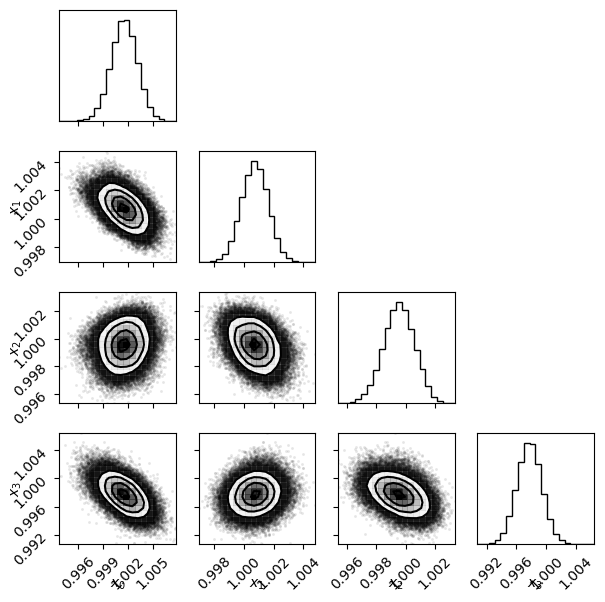

In [21]:
fig = vps[0].plot();

vps[0].moments()

In [23]:
from n_dim_Del_integral import Del_integral_n_dim
I = Del_integral_n_dim(vps[0], np.array([[1.,1.,1.,1.]]), int(1e5), num_clusts=0, lower_thresh_const = 1.0)
print(I)

[0.6197193]


In [11]:
from n_dim_Del_integral import Del_integral_n_dim
I = Del_integral_n_dim(vps[0], np.array([[1.,1.,1.,1.]]), int(5e5), num_clusts=0, lower_thresh_const=.75)
print(I)

[0.99740193]


In [28]:
from n_dim_Del_integral import Del_integral_n_dim
metrics2 = []
for i,vp in enumerate(vps):
    metrics2.append(Del_integral_n_dim(vp, np.array([[1.,1.,1.,1.]]), int(1e5), num_clusts=0, lower_thresh_const=.75))
    print(i)

0
1
2
3


QhullError: QH6417 qhull precision error (qh_merge_twisted): twisted facet f314797 does not contain pinched vertices.  Too wide to merge into neighbor.  mindist -1.7e-09 maxdist 1.4e-13 vertexdist 1.3e-07 maxpinched 7.4e-13 neighbor f351242 mindist -3.3e-12 maxdist  0
ERRONEOUS FACET:
- f314797
    - flags: bottom newfacet tested keepcentrum newmerge
    - merges: 122
    - normal:    0.4714    0.471   0.4704   0.4695  -0.3378
    - offset:  -1.674709
    - center: 1.001579412937134 1.000739560630582 0.9994822686917374 0.9975855025510382 0.6141745104511371 
    - vertices: p5941(v3768) p84341(v3767) p73641(v3487) p82666(v3422) p82748(v3113) p41670(v3112) p65257(v3015) p85704(v2659) p85776(v2658) p24106(v2532) p51131(v2383) p68801(v2288) p21546(v1774) p55119(v1711) p13584(v1420) p22417(v1293) p99151(v1066) p4031(v1030) p84789(v768) p23774(v634) p98847(v88)
    - neighboring facets: f350136 f351242 f336794 f225639 f350759 f249367 f272495 f263428 f272351 f272385 f314792 f225584 f314883 f272192 f350139 f285983 f272238 f225561 f249415 f199018 f272242 f314807 f350438 f272188
    - ridges:
     - r591610 tested simplicialtop
           vertices: p5941(v3768) p51131(v2383) p21546(v1774) p98847(v88)
           between f350136 and f314797
     - r591609 tested
           vertices: p5941(v3768) p21546(v1774) p99151(v1066) p98847(v88)
           between f350136 and f314797
     - r503403 tested
           vertices: p82666(v3422) p65257(v3015) p85704(v2659) p24106(v2532)
           between f351242 and f314797
     - r591533 tested nonconvex
           vertices: p82666(v3422) p85704(v2659) p24106(v2532) p23774(v634)
           between f314797 and f351242
     - r520037 tested
           vertices: p73641(v3487) p82666(v3422) p65257(v3015) p85704(v2659)
           between f351242 and f314797
     - r520040 tested
           vertices: p73641(v3487) p82666(v3422) p65257(v3015) p24106(v2532)
           between f314797 and f351242
     - r520103 tested
           vertices: p73641(v3487) p65257(v3015) p85704(v2659) p24106(v2532)
           between f314797 and f351242
     - r591540 tested
           vertices: p5941(v3768) p85704(v2659) p55119(v1711) p23774(v634)
           between f351242 and f314797
     - r591536 tested
           vertices: p5941(v3768) p82666(v3422) p85704(v2659) p23774(v634)
           between f351242 and f314797
     - r591757 tested
           vertices: p73641(v3487) p82666(v3422) p99151(v1066) p23774(v634)
           between f351242 and f314797
     - r590859 tested
           vertices: p5941(v3768) p73641(v3487) p82666(v3422) p85704(v2659)
           between f314797 and f351242
     - r591599 tested
           vertices: p5941(v3768) p84341(v3767) p99151(v1066) p23774(v634)
           between f351242 and f314797
     - r591761 tested
           vertices: p73641(v3487) p82666(v3422) p24106(v2532) p23774(v634)
           between f314797 and f351242
     - r591760 tested
           vertices: p5941(v3768) p73641(v3487) p82666(v3422) p99151(v1066)
           between f351242 and f314797
     - r591202 tested
           vertices: p5941(v3768) p41670(v3112) p85704(v2659) p55119(v1711)
           between f314797 and f351242
     - r591598 tested
           vertices: p5941(v3768) p82666(v3422) p99151(v1066) p23774(v634)
           between f314797 and f351242
     - r591133 tested
           vertices: p5941(v3768) p41670(v3112) p85776(v2658) p55119(v1711)
           between f351242 and f314797
     - r520032 tested
           vertices: p73641(v3487) p24106(v2532) p21546(v1774) p23774(v634)
           between f314797 and f336794
     - r593202 tested simplicialbot
           vertices: p85704(v2659) p21546(v1774) p13584(v1420) p84789(v768)
           between f314797 and f225639
     - r520136 tested
           vertices: p73641(v3487) p82748(v3113) p85704(v2659) p84789(v768)
           between f314797 and f350759
     - r592598 tested
           vertices: p73641(v3487) p13584(v1420) p22417(v1293) p84789(v768)
           between f350759 and f314797
     - r520138 tested
           vertices: p73641(v3487) p85704(v2659) p22417(v1293) p84789(v768)
           between f314797 and f350759
     - r592591 tested
           vertices: p85704(v2659) p13584(v1420) p22417(v1293) p84789(v768)
           between f314797 and f350759
     - r520104 tested
           vertices: p73641(v3487) p82748(v3113) p65257(v3015) p24106(v2532)
           between f314797 and f350759
     - r520094 tested
           vertices: p73641(v3487) p82748(v3113) p85704(v2659) p24106(v2532)
           between f350759 and f314797
     - r592563 tested
           vertices: p5941(v3768) p73641(v3487) p85704(v2659) p22417(v1293)
           between f314797 and f350759
     - r591596 tested
           vertices: p5941(v3768) p85704(v2659) p68801(v2288) p13584(v1420)
           between f314797 and f350759
     - r592552 tested
           vertices: p5941(v3768) p73641(v3487) p13584(v1420) p22417(v1293)
           between f350759 and f314797
     - r591556 tested
           vertices: p5941(v3768) p85704(v2659) p13584(v1420) p22417(v1293)
           between f314797 and f350759
     - r591592 tested
           vertices: p5941(v3768) p51131(v2383) p68801(v2288) p13584(v1420)
           between f350759 and f314797
     - r591601 tested
           vertices: p5941(v3768) p41670(v3112) p85776(v2658) p68801(v2288)
           between f314797 and f350759
     - r591602 tested
           vertices: p5941(v3768) p41670(v3112) p85704(v2659) p68801(v2288)
           between f350759 and f314797
     - r203817 tested simplicialbot
           vertices: p21546(v1774) p55119(v1711) p4031(v1030) p98847(v88)
           between f314797 and f249367
     - r203813 tested
           vertices: p21546(v1774) p55119(v1711) p99151(v1066) p98847(v88)
           between f249367 and f314797
     - r351377 tested simplicialbot
           vertices: p21546(v1774) p55119(v1711) p99151(v1066) p23774(v634)
           between f314797 and f272495
     - r520151 tested
           vertices: p73641(v3487) p82748(v3113) p21546(v1774) p84789(v768)
           between f263428 and f314797
     - r520108 tested
           vertices: p73641(v3487) p82748(v3113) p65257(v3015) p21546(v1774)
           between f263428 and f314797
     - r503400 tested simplicialbot
           vertices: p82748(v3113) p65257(v3015) p24106(v2532) p21546(v1774)
           between f314797 and f272351
     - r520324 tested simplicialtop
           vertices: p82748(v3113) p85704(v2659) p21546(v1774) p84789(v768)
           between f272385 and f314797
     - r520125 tested
           vertices: p73641(v3487) p65257(v3015) p24106(v2532) p21546(v1774)
           between f314792 and f314797
     - r438276 tested
           vertices: p82748(v3113) p85704(v2659) p24106(v2532) p21546(v1774)
           between f225584 and f314797
     - r438280 tested simplicialtop
           vertices: p85704(v2659) p24106(v2532) p21546(v1774) p23774(v634)
           between f225584 and f314797
     - r520328 tested simplicialbot
           vertices: p73641(v3487) p21546(v1774) p99151(v1066) p23774(v634)
           between f314797 and f314883
     - r590599 tested simplicialbot
           vertices: p41670(v3112) p85776(v2658) p21546(v1774) p55119(v1711)
           between f314797 and f272192
     - r592234 tested
           vertices: p5941(v3768) p73641(v3487) p21546(v1774) p99151(v1066)
           between f314797 and f350139
     - r463783 tested
           vertices: p85776(v2658) p68801(v2288) p21546(v1774) p4031(v1030)
           between f314797 and f285983
     - r351265 tested
           vertices: p85776(v2658) p21546(v1774) p55119(v1711) p4031(v1030)
           between f314797 and f285983
     - r590601 tested simplicialbot
           vertices: p41670(v3112) p85776(v2658) p68801(v2288) p21546(v1774)
           between f314797 and f272238
     - r351433 tested simplicialtop
           vertices: p85704(v2659) p68801(v2288) p21546(v1774) p13584(v1420)
           between f225561 and f314797
     - r300813 tested
           vertices: p51131(v2383) p68801(v2288) p21546(v1774) p98847(v88)
           between f249415 and f314797
     - r394262 tested simplicialbot
           vertices: p68801(v2288) p21546(v1774) p4031(v1030) p98847(v88)
           between f314797 and f249415
     - r351314 tested simplicialbot
           vertices: p51131(v2383) p68801(v2288) p21546(v1774) p13584(v1420)
           between f314797 and f199018
     - r590602 tested simplicialtop
           vertices: p41670(v3112) p85704(v2659) p68801(v2288) p21546(v1774)
           between f272242 and f314797
     - r520332 tested
           vertices: p73641(v3487) p21546(v1774) p13584(v1420) p84789(v768)
           between f314807 and f314797
     - r590830 tested
           vertices: p5941(v3768) p73641(v3487) p51131(v2383) p21546(v1774)
           between f314797 and f314807
     - r520335 tested
           vertices: p73641(v3487) p51131(v2383) p21546(v1774) p13584(v1420)
           between f314797 and f314807
     - r590835 tested simplicialtop
           vertices: p5941(v3768) p73641(v3487) p51131(v2383) p13584(v1420)
           between f314807 and f314797
     - r591136 tested
           vertices: p5941(v3768) p85776(v2658) p68801(v2288) p4031(v1030)
           between f350438 and f314797
     - r591112 tested
           vertices: p5941(v3768) p84341(v3767) p55119(v1711) p98847(v88)
           between f350438 and f314797
     - r591125 tested
           vertices: p5941(v3768) p55119(v1711) p4031(v1030) p98847(v88)
           between f350438 and f314797
     - r589948 tested
           vertices: p84341(v3767) p55119(v1711) p99151(v1066) p98847(v88)
           between f314797 and f350438
     - r589916 tested
           vertices: p84341(v3767) p55119(v1711) p99151(v1066) p23774(v634)
           between f350438 and f314797
     - r590749 tested
           vertices: p5941(v3768) p84341(v3767) p55119(v1711) p23774(v634)
           between f314797 and f350438
     - r591130 tested
           vertices: p5941(v3768) p68801(v2288) p4031(v1030) p98847(v88)
           between f314797 and f350438
     - r591111 tested
           vertices: p5941(v3768) p84341(v3767) p99151(v1066) p98847(v88)
           between f314797 and f350438
     - r591595 tested
           vertices: p5941(v3768) p51131(v2383) p68801(v2288) p98847(v88)
           between f314797 and f350438
     - r591124 tested
           vertices: p5941(v3768) p85776(v2658) p55119(v1711) p4031(v1030)
           between f314797 and f350438
     - r439010 tested
           vertices: p41670(v3112) p85704(v2659) p21546(v1774) p55119(v1711)
           between f272188 and f314797
     - r351595 tested
           vertices: p85704(v2659) p21546(v1774) p55119(v1711) p23774(v634)
           between f272188 and f314797
ERRONEOUS OTHER FACET:
- f351242
    - flags: top newfacet tested keepcentrum newmerge
    - merges: 46
    - normal:    0.4714    0.471   0.4704   0.4695  -0.3378
    - offset:  -1.674716
    - center: 1.001576077903921 1.000740619280516 0.9994886727450745 0.9975901395585628 0.6141866970675601 
    - maxoutside: 1.264544e-13
    - vertices: p95411(v3770) p5941(v3768) p84341(v3767) p59576(v3587) p73641(v3487) p82666(v3422) p64713(v3115) p82748(v3113) p41670(v3112) p62565(v3095) p65257(v3015) p85704(v2659) p85776(v2658) p93329(v2629) p94499(v2628) p24106(v2532) p43896(v2162) p91426(v2024) p93729(v2020) p55119(v1711) p73590(v1583) p91094(v1181) p99151(v1066) p23774(v634)
    - neighboring facets: f350438 f351215 f350759 f272192 f297175 f329202 f350961 f351277 f225584 f314797 f318054 f351209 f272368 f272413 f336794 f314883 f272188 f272741 f351217
    - ridges:
     - r592088 tested simplicialtop
           vertices: p5941(v3768) p94499(v2628) p73590(v1583) p91094(v1181)
           between f351242 and f350438
     - r592321 tested
           vertices: p5941(v3768) p93329(v2629) p94499(v2628) p73590(v1583)
           between f350438 and f351242
     - r591854 tested
           vertices: p5941(v3768) p59576(v3587) p73590(v1583) p91094(v1181)
           between f350438 and f351242
     - r592494 tested
           vertices: p5941(v3768) p59576(v3587) p24106(v2532) p93729(v2020)
           between f351242 and f350438
     - r591537 tested
           vertices: p5941(v3768) p24106(v2532) p93729(v2020) p23774(v634)
           between f350438 and f351242
     - r592076 tested
           vertices: p5941(v3768) p84341(v3767) p73641(v3487) p24106(v2532)
           between f350438 and f351242
     - r592253 tested
           vertices: p5941(v3768) p84341(v3767) p73641(v3487) p99151(v1066)
           between f351242 and f350438
     - r592544 tested
           vertices: p5941(v3768) p84341(v3767) p24106(v2532) p23774(v634)
           between f350438 and f351242
     - r591849 tested
           vertices: p5941(v3768) p59576(v3587) p93729(v2020) p91094(v1181)
           between f351242 and f350438
     - r591753 tested
           vertices: p5941(v3768) p64713(v3115) p62565(v3095) p94499(v2628)
           between f350438 and f351242
     - r591785 tested
           vertices: p5941(v3768) p64713(v3115) p62565(v3095) p93729(v2020)
           between f351242 and f350438
     - r590863 tested
           vertices: p5941(v3768) p62565(v3095) p94499(v2628) p91094(v1181)
           between f351242 and f350438
     - r590862 tested
           vertices: p5941(v3768) p62565(v3095) p93729(v2020) p91094(v1181)
           between f350438 and f351242
     - r590725 tested
           vertices: p5941(v3768) p64713(v3115) p94499(v2628) p43896(v2162)
           between f350438 and f351242
     - r591781 tested
           vertices: p5941(v3768) p64713(v3115) p93729(v2020) p23774(v634)
           between f351242 and f350438
     - r591797 tested
           vertices: p5941(v3768) p64713(v3115) p43896(v2162) p55119(v1711)
           between f350438 and f351242
     - r591122 tested
           vertices: p5941(v3768) p85776(v2658) p43896(v2162) p55119(v1711)
           between f351242 and f350438
     - r590948 tested
           vertices: p5941(v3768) p64713(v3115) p55119(v1711) p23774(v634)
           between f350438 and f351242
     - r593075 tested simplicialtop simplicialbot
           vertices: p95411(v3770) p94499(v2628) p73590(v1583) p91094(v1181)
           between f351215 and f351242
     - r593130 tested
           vertices: p95411(v3770) p91426(v2024) p73590(v1583) p91094(v1181)
           between f351242 and f351215
     - r592987 tested
           vertices: p95411(v3770) p91426(v2024) p93729(v2020) p91094(v1181)
           between f351215 and f351242
     - r592998 tested simplicialtop
           vertices: p95411(v3770) p5941(v3768) p91426(v2024) p73590(v1583)
           between f350759 and f351242
     - r591855 tested
           vertices: p5941(v3768) p59576(v3587) p91426(v2024) p73590(v1583)
           between f350759 and f351242
     - r593020 tested
           vertices: p95411(v3770) p5941(v3768) p93329(v2629) p73590(v1583)
           between f351242 and f350759
     - r592168 tested
           vertices: p5941(v3768) p82748(v3113) p41670(v3112) p91426(v2024)
           between f350759 and f351242
     - r592062 tested
           vertices: p5941(v3768) p82748(v3113) p85704(v2659) p24106(v2532)
           between f351242 and f350759
     - r593033 tested
           vertices: p95411(v3770) p82748(v3113) p41670(v3112) p91426(v2024)
           between f351242 and f350759
     - r592225 tested
           vertices: p5941(v3768) p82748(v3113) p41670(v3112) p85704(v2659)
           between f351242 and f350759
     - r592399 tested
           vertices: p5941(v3768) p59576(v3587) p82748(v3113) p91426(v2024)
           between f350759 and f351242
     - r591572 tested
           vertices: p5941(v3768) p59576(v3587) p82748(v3113) p24106(v2532)
           between f351242 and f350759
     - r590788 tested
           vertices: p5941(v3768) p73641(v3487) p85704(v2659) p24106(v2532)
           between f350759 and f351242
     - r593017 tested
           vertices: p95411(v3770) p5941(v3768) p41670(v3112) p91426(v2024)
           between f350759 and f351242
     - r593061 tested
           vertices: p95411(v3770) p5941(v3768) p41670(v3112) p85776(v2658)
           between f351242 and f350759
     - r593198 tested simplicialtop
           vertices: p41670(v3112) p85776(v2658) p43896(v2162) p55119(v1711)
           between f272192 and f351242
     - r593102 tested
           vertices: p95411(v3770) p93329(v2629) p94499(v2628) p73590(v1583)
           between f351242 and f297175
     - r546538 tested
           vertices: p59576(v3587) p91426(v2024) p93729(v2020) p91094(v1181)
           between f351242 and f329202
     - r591852 tested simplicialtop
           vertices: p59576(v3587) p91426(v2024) p73590(v1583) p91094(v1181)
           between f329202 and f351242
     - r593032 tested
           vertices: p95411(v3770) p5941(v3768) p93329(v2629) p94499(v2628)
           between f350961 and f351242
     - r593027 tested
           vertices: p95411(v3770) p5941(v3768) p85776(v2658) p43896(v2162)
           between f351242 and f350961
     - r593029 tested
           vertices: p95411(v3770) p5941(v3768) p94499(v2628) p43896(v2162)
           between f350961 and f351242
     - r593026 tested
           vertices: p95411(v3770) p41670(v3112) p85776(v2658) p43896(v2162)
           between f350961 and f351242
     - r593128 tested
           vertices: p95411(v3770) p82748(v3113) p91426(v2024) p93729(v2020)
           between f351242 and f351277
     - r593129 tested simplicialtop
           vertices: p95411(v3770) p82748(v3113) p41670(v3112) p93729(v2020)
           between f351277 and f351242
     - r438277 tested
           vertices: p82748(v3113) p85704(v2659) p24106(v2532) p93729(v2020)
           between f351242 and f225584
     - r435729 tested simplicialbot
           vertices: p85704(v2659) p24106(v2532) p93729(v2020) p23774(v634)
           between f351242 and f225584
     - r591533 tested nonconvex
           vertices: p82666(v3422) p85704(v2659) p24106(v2532) p23774(v634)
           between f314797 and f351242
     - r591757 tested
           vertices: p73641(v3487) p82666(v3422) p99151(v1066) p23774(v634)
           between f351242 and f314797
     - r591536 tested
           vertices: p5941(v3768) p82666(v3422) p85704(v2659) p23774(v634)
           between f351242 and f314797
     - r520103 tested
           vertices: p73641(v3487) p65257(v3015) p85704(v2659) p24106(v2532)
           between f314797 and f351242
     - r591598 tested
           vertices: p5941(v3768) p82666(v3422) p99151(v1066) p23774(v634)
           between f314797 and f351242
     - r591760 tested
           vertices: p5941(v3768) p73641(v3487) p82666(v3422) p99151(v1066)
           between f351242 and f314797
     - r520037 tested
           vertices: p73641(v3487) p82666(v3422) p65257(v3015) p85704(v2659)
           between f351242 and f314797
     - r591761 tested
           vertices: p73641(v3487) p82666(v3422) p24106(v2532) p23774(v634)
           between f314797 and f351242
     - r590859 tested
           vertices: p5941(v3768) p73641(v3487) p82666(v3422) p85704(v2659)
           between f314797 and f351242
     - r520040 tested
           vertices: p73641(v3487) p82666(v3422) p65257(v3015) p24106(v2532)
           between f314797 and f351242
     - r503403 tested
           vertices: p82666(v3422) p65257(v3015) p85704(v2659) p24106(v2532)
           between f351242 and f314797
     - r591599 tested
           vertices: p5941(v3768) p84341(v3767) p99151(v1066) p23774(v634)
           between f351242 and f314797
     - r591133 tested
           vertices: p5941(v3768) p41670(v3112) p85776(v2658) p55119(v1711)
           between f351242 and f314797
     - r591540 tested
           vertices: p5941(v3768) p85704(v2659) p55119(v1711) p23774(v634)
           between f351242 and f314797
     - r591202 tested
           vertices: p5941(v3768) p41670(v3112) p85704(v2659) p55119(v1711)
           between f314797 and f351242
     - r438971 tested
           vertices: p64713(v3115) p62565(v3095) p94499(v2628) p93729(v2020)
           between f318054 and f351242
     - r435775 tested
           vertices: p62565(v3095) p94499(v2628) p93729(v2020) p91094(v1181)
           between f318054 and f351242
     - r593161 tested
           vertices: p95411(v3770) p64713(v3115) p41670(v3112) p43896(v2162)
           between f351209 and f351242
     - r593164 tested simplicialbot
           vertices: p95411(v3770) p64713(v3115) p41670(v3112) p93729(v2020)
           between f351242 and f351209
     - r592342 tested simplicialbot
           vertices: p82748(v3113) p41670(v3112) p85704(v2659) p93729(v2020)
           between f351242 and f272368
     - r547149 tested
           vertices: p59576(v3587) p82748(v3113) p91426(v2024) p93729(v2020)
           between f272413 and f351242
     - r547150 tested
           vertices: p59576(v3587) p82748(v3113) p24106(v2532) p93729(v2020)
           between f351242 and f272413
     - r589476 tested
           vertices: p84341(v3767) p73641(v3487) p24106(v2532) p23774(v634)
           between f336794 and f351242
     - r589480 tested
           vertices: p84341(v3767) p73641(v3487) p99151(v1066) p23774(v634)
           between f351242 and f314883
     - r437957 tested simplicialbot
           vertices: p41670(v3112) p85704(v2659) p93729(v2020) p23774(v634)
           between f351242 and f272188
     - r438809 tested
           vertices: p64713(v3115) p41670(v3112) p85704(v2659) p23774(v634)
           between f272188 and f351242
     - r438999 tested
           vertices: p64713(v3115) p41670(v3112) p85704(v2659) p55119(v1711)
           between f351242 and f272188
     - r438804 tested
           vertices: p64713(v3115) p41670(v3112) p93729(v2020) p23774(v634)
           between f351242 and f272188
     - r438997 tested
           vertices: p64713(v3115) p85704(v2659) p55119(v1711) p23774(v634)
           between f272188 and f351242
     - r593177 tested simplicialtop
           vertices: p64713(v3115) p41670(v3112) p43896(v2162) p55119(v1711)
           between f272741 and f351242
     - r593077 tested
           vertices: p95411(v3770) p64713(v3115) p94499(v2628) p93729(v2020)
           between f351217 and f351242
     - r593093 tested
           vertices: p95411(v3770) p94499(v2628) p93729(v2020) p91094(v1181)
           between f351242 and f351217
     - r593087 tested
           vertices: p95411(v3770) p64713(v3115) p94499(v2628) p43896(v2162)
           between f351242 and f351217

While executing:  | qhull d Qz Q12 Qbb Qt Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1918747710  delaunay  Qz-infinity-point  Q12-allow-wide  Qbbound-last
  Qtriangulate  Qcoplanar-keep  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 0.9  Error-roundoff 3.4e-15  _one-merge 3.7e-14
  Visible-distance 2e-14  U-max-coplanar 2e-14  Width-outside 4e-14
  _wide-facet 1.2e-13  _maxoutside 2.1e-11
Last point added to hull was p95411.  Last merge was #204933.

At error exit:

Delaunay triangulation by the convex hull of 100001 points in 5-d:

  Number of input sites and at-infinity: 2845
  Total number of deleted points due to merging: 925
  Number of nearly incident points: 94825
  Number of Delaunay regions: 19238
  Number of non-simplicial Delaunay regions: 5330

Statistics for:  | qhull d Qz Q12 Qbb Qt Qc

  Number of points processed: 3770
  Number of hyperplanes created: 290519
  Number of facets in hull: 19243
  Number of distance tests for qhull: -916306151
  Number of distance tests for merging: 17838949
  Number of distance tests for checking: 0
  Number of merged facets: 227699
  Maximum distance of point above facet: 2.1e-11 (528.8x)
  Maximum distance of vertex below facet: -3.5e-11 (882.1x)


precision problems (corrected unless 'Q0' or an error)
  13805 flipped facets
  22717 coplanar horizon facets for new vertices
  94825 coplanar points during partitioning
      1 dupridges with multiple neighbors
   2097 dupridges with flip facet into good neighbor
     68 dupridges with flip facet into good flip neighbor

A wide merge error has occurred.  Qhull has produced a wide facet due to facet merges and vertex merges.
This usually occurs when the input is nearly degenerate and substantial merging has occurred.
See http://www.qhull.org/html/qh-impre.htm#limit


In [ ]:
np.concatenate(metrics2,metrics[0:3])

[array([0.68542135]),
 array([0.74330301]),
 array([0.7024862]),
 array([0.6469844])]

In [ ]:
for i,vp in enumerate(vps):
    vp.plot();
    

In [ ]:
vp = vps[0]
Xs,_ = vp.sample(int(2e3))
plt.quiver(Xs[:,0],Xs[:,1],Xs[:,2],Xs[:,3],scale = 20)

plt.show()

In [ ]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt

# Meshgrid
x, y = np.meshgrid(np.linspace(-5, 5, 10),
				np.linspace(-5, 5, 10))

# Directional vectors
u = -y/np.sqrt(x**2 + y**2)
v = x/(x**2 + y**2)

# Plotting Vector Field with QUIVER
plt.quiver(x, y, u, v, color='g')
plt.title('Vector Field')

# Setting x, y boundary limits
plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Show plot with grid
plt.grid()
plt.show()
